In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nycrollingsales/nyc-rolling-sales.csv


In [2]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [3]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
data = pd.read_csv('../input/nycrollingsales/nyc-rolling-sales.csv')
df = data.copy()

## 1. Exploratory Data Analysis:

In [5]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [6]:
# empty data points are not set up properly
df = df.replace(' -  ', np.nan)
df = df.replace(' ', np.nan)
df = df[df['LAND SQUARE FEET'].notna()]
df = df[df['GROSS SQUARE FEET'].notna()]
df = df[df['SALE PRICE'].notna()]

In [7]:

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Nunique #####################")
    print(dataframe.nunique())
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)    
check_df(df)

##################### Shape #####################
(48244, 22)
##################### Types #####################
Unnamed: 0                          int64
BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                         object
SALE D

### DATA PREPROCESSING

In [8]:
## INITIAL PREPROCESSING ##
# Object ===> numeric
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors = 'coerce')
df['LAND SQUARE FEET'] =  pd.to_numeric(df['LAND SQUARE FEET'], errors = 'coerce')
df['SALE PRICE'] =  pd.to_numeric(df['SALE PRICE'], errors = 'coerce')
# this column was empty
df = df.drop('EASE-MENT',axis=1)
df = df.drop('Unnamed: 0',axis=1)
# Deleting duplicate values

df = df.drop_duplicates(df.columns, keep='last')
#sum(df.duplicated(df.columns))

In [9]:
df.shape

(47896, 20)

In [10]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if (dataframe[col].nunique() < cat_th) &
                   (dataframe[col].dtypes != "O")]

    cat_but_car = [col for col in dataframe.columns if (dataframe[col].nunique() > car_th) &
                   (dataframe[col].dtypes == "O")]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols, num_but_cat


cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)


Observations: 47896
Variables: 20
cat_cols: 3
num_cols: 10
cat_but_car: 7
num_but_cat: 2


In [11]:
cat_cols

['TAX CLASS AT PRESENT', 'BOROUGH', 'TAX CLASS AT TIME OF SALE']

In [12]:
df['TAX CLASS AT TIME OF SALE'].value_counts()

1    32277
2    12119
4     3498
3        2
Name: TAX CLASS AT TIME OF SALE, dtype: int64

In [13]:
df['TAX CLASS AT PRESENT'].value_counts()

1     31036
2      7959
4      3404
2A     2075
2C     1229
2B      635
1A      546
1B      492
1C      166
3         2
Name: TAX CLASS AT PRESENT, dtype: int64

## 1.1 Analysis of Categorical Features:

    TAX CLASS AT PRESENT  Ratio
1                  31036 64.799
2                   7959 16.617
4                   3404  7.107
2A                  2075  4.332
2C                  1229  2.566
2B                   635  1.326
1A                   546  1.140
1B                   492  1.027
1C                   166  0.347
3                      2  0.004


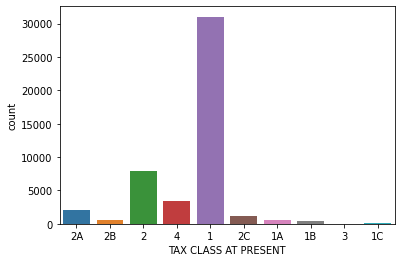

   BOROUGH  Ratio
3    23843 49.781
4    11053 23.077
2     6994 14.602
5     5041 10.525
1      965  2.015


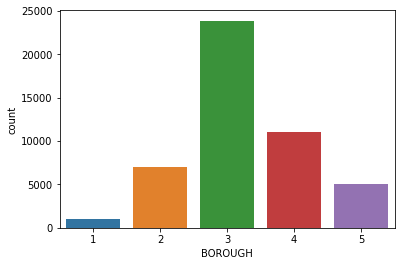

   TAX CLASS AT TIME OF SALE  Ratio
1                      32277 67.390
2                      12119 25.303
4                       3498  7.303
3                          2  0.004


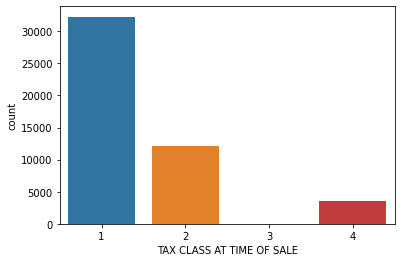

In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col,plot = True)

****CAP 1 -  Analysis for Categorics****
1. CLASS 1 and CLASS 2 tax payers (at present) composes almost 82 percent of the whole population.
2. CLASS 4, CLASS 3, CLASS 1 BOROUGH composes almost 80 percent of the whole population.
3. CLASS 1 and CLASS 2 tax payers (at the time of sale) composes almost 81.
4. 3rd Day of the week is the day which the most sales happened. 3rd, 2nd,4th are close to each other. 5th and 6th days are low.
5. Outcome: For the data with low volumes, we can encode them as 'RARE'. Like for the ' sale day of week' feature, we can combine and encode 5th and 6th days as 'RARE'. Because their total ratio is almost 1.5% of the whole data.

## 1.2 Analysis of Numerical Features

count   47896.000
mean     4994.515
std      3429.465
min         1.000
5%        409.000
10%       962.000
20%      1775.000
30%      2722.000
40%      3683.000
50%      4666.000
60%      5500.000
70%      6372.000
80%      7618.000
90%      9422.000
95%     11966.000
99%     15588.350
max     16319.000
Name: BLOCK, dtype: float64
#####################################
count   47896.000
mean      234.777
std       495.924
min         1.000
5%          4.000
10%         9.000
20%        17.000
30%        26.000
40%        35.000
50%        45.000
60%        57.000
70%        73.000
80%       142.000
90%      1033.000
95%      1206.000
99%      1993.050
max      9009.000
Name: LOT, dtype: float64
#####################################
count   47896.000
mean    10940.164
std      1074.739
min         0.000
5%      10304.000
10%     10312.000
20%     10463.000
30%     11201.000
40%     11209.000
50%     11217.000
60%     11226.000
70%     11234.000
80%     11357.000
90%     11414.000
95%   

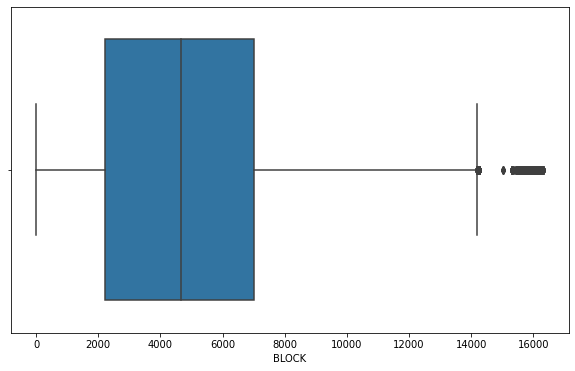

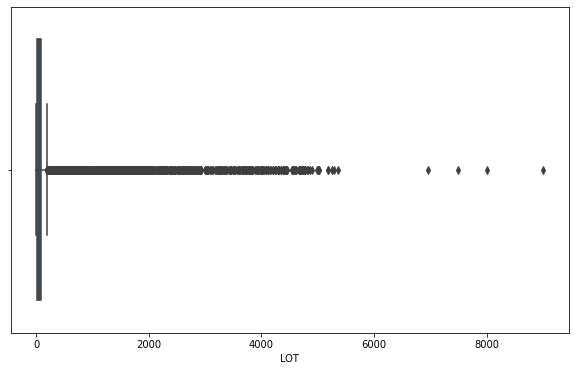

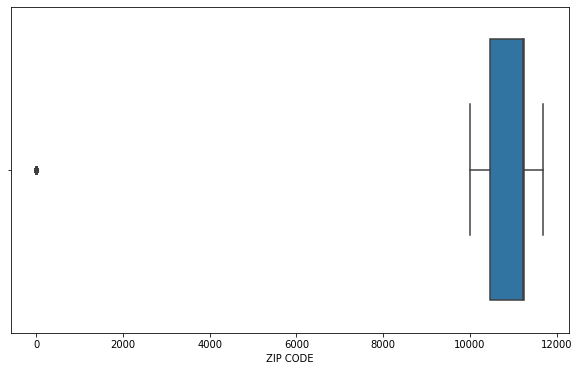

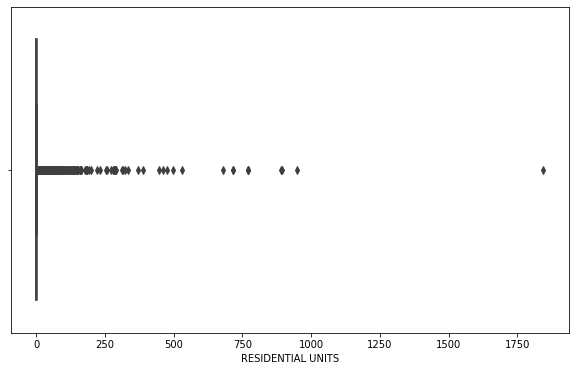

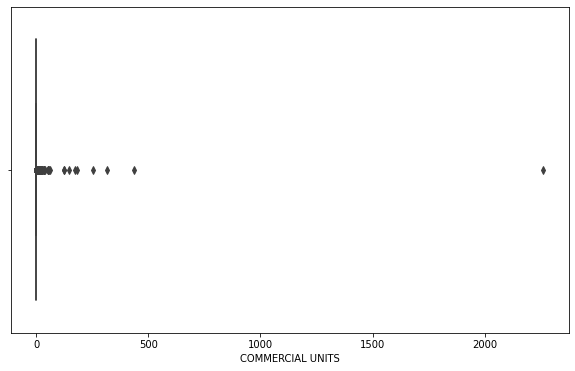

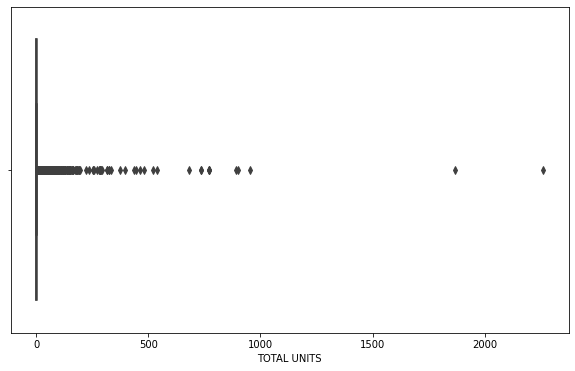

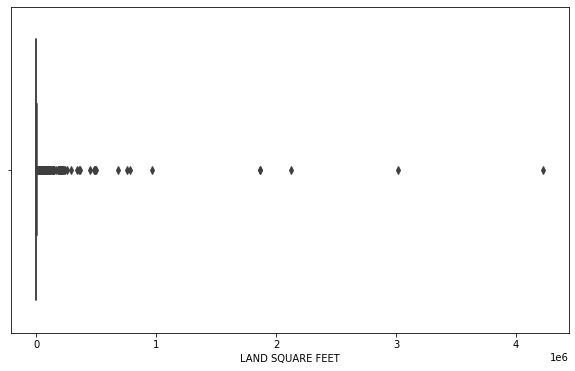

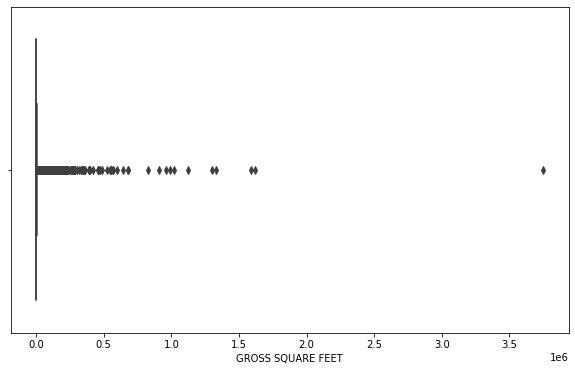

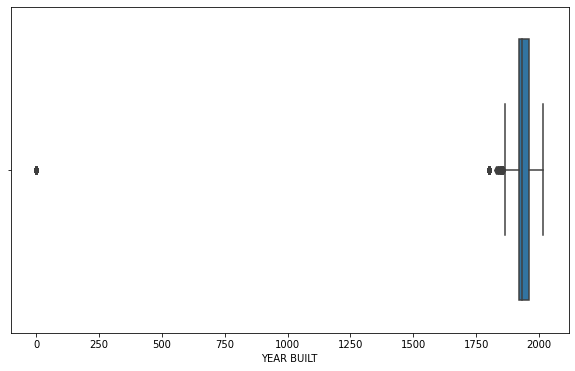

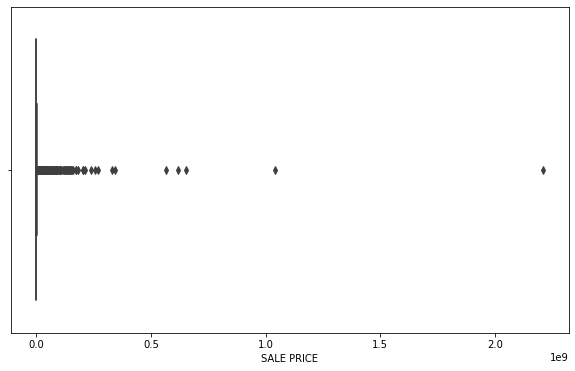

In [15]:

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        plt.figure(figsize=(10,6))
        sns.boxplot(x=numerical_col, data=df)
        
        #dataframe[numerical_col].hist(bins = 100)
        #plt.xlabel(numerical_col)
        #plt.title(numerical_col)
        #plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(df, col,plot = True)

In [16]:
## Initial Preprocessing 2 ##

# Getting Rid of Impossible Values:
df[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)
df = df[(df['TOTAL UNITS'] > 0)] 

## 1.3 Comparing Target Variable against Categorical Features

In [17]:
######################################
# 4. Hedef Değişkeni Kategorik Degiskenler ile Karsilastirma
######################################
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"COUNT": df[categorical_col].value_counts(),
                    "RATIO": df[categorical_col].value_counts() / len(df),
                    target: df.groupby(categorical_col)[target].mean()}).sort_values([target],ascending = False), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SALE PRICE",col)

    COUNT  RATIO  SALE PRICE
4    2915  0.068 5981297.361
2    4428  0.104 2616112.808
2B    635  0.015 2558758.496
2A   2075  0.049  984384.160
1C    166  0.004  813752.307
1B     30  0.001  749847.400
2C    985  0.023  719411.146
1   30967  0.724  604166.963
1A    546  0.013  415253.216


   COUNT  RATIO   SALE PRICE
1    963  0.023 19246955.335
4  11041  0.258   907913.974
3  20153  0.471   868244.621
2   5552  0.130   680124.052
5   5038  0.118   527257.684


   COUNT  RATIO  SALE PRICE
4   2926  0.068 5988436.452
2   8106  0.190 1959350.852
1  31715  0.742  601751.219




TAX CLASS 4, CLASS 2B and CLASS UNKNOWN has the highest SALE PRICE. \
TAX CLASS AT TIME OF SALE ---> 4 has the highest sale price, then 2, then 3 and 1 almost equal.\
In the 4th and 2nd quarter, sale price is higher than the other quarters.\
Sale Prices are in 4th, 3rd, and 1st  day of the week.

In [18]:
cat_cols

['TAX CLASS AT PRESENT', 'BOROUGH', 'TAX CLASS AT TIME OF SALE']

In [19]:
print(pd.DataFrame({"COUNT": df['TAX CLASS AT PRESENT'].value_counts(),
                    "RATIO": df['TAX CLASS AT PRESENT'].value_counts() / len(df),
                    "TOTAL UNITS": df.groupby('TAX CLASS AT PRESENT' )['TOTAL UNITS'].mean(),
                    "SALE PRICE": df.groupby('TAX CLASS AT PRESENT' )['SALE PRICE'].mean()}).sort_values(['RATIO','SALE PRICE'],ascending = False), end="\n\n\n")

    COUNT  RATIO  TOTAL UNITS  SALE PRICE
1   30967  0.724        1.686  604166.963
2    4428  0.104       11.994 2616112.808
4    2915  0.068        3.944 5981297.361
2A   2075  0.049        4.733  984384.160
2C    985  0.023        1.026  719411.146
2B    635  0.015        8.315 2558758.496
1A    546  0.013        1.000  415253.216
1C    166  0.004        1.000  813752.307
1B     30  0.001        1.767  749847.400




In [20]:
print(pd.DataFrame({"COUNT": df['TAX CLASS AT TIME OF SALE'].value_counts(),
                    "RATIO": df['TAX CLASS AT TIME OF SALE'].value_counts() / len(df),
                    "TOTAL UNITS": df.groupby('TAX CLASS AT TIME OF SALE' )['TOTAL UNITS'].mean(),
                    "SALE PRICE": df.groupby('TAX CLASS AT TIME OF SALE' )['SALE PRICE'].mean()}).sort_values(['RATIO','SALE PRICE'],ascending = False), end="\n\n\n")

   COUNT  RATIO  TOTAL UNITS  SALE PRICE
1  31715  0.742        1.675  601751.219
2   8106  0.190        8.516 1959350.852
4   2926  0.068        3.940 5988436.452




## 1.4 Analysis of Categorics with High Cardinality

In [21]:
cat_but_car

['NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'APARTMENT NUMBER',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE DATE']

In [22]:
#df.loc[~df['BUILDING CLASS AT TIME OF SALE'].str.contains('R4|A1|A5|B2|B1|C0|B3'), 'BUILDING CLASS AT TIME OF SALE'] = 'Other Class'
df['BUILDING CLASS AT TIME OF SALE'] = df['BUILDING CLASS AT TIME OF SALE'].astype('object')

In [23]:
df['BUILDING CLASS CATEGORY'].value_counts()
top = df['BUILDING CLASS CATEGORY'].value_counts().head(7).index.tolist()
df.loc[~df['BUILDING CLASS CATEGORY'].isin(top), 'BUILDING CLASS CATEGORY'] = '00 OTHER'
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].astype('object')

In [24]:
print(pd.DataFrame({"COUNT": df['BUILDING CLASS CATEGORY'].value_counts(),
                    "RATIO": df['BUILDING CLASS CATEGORY'].value_counts() / len(df),
                    "SALE PRICE": df.groupby('BUILDING CLASS CATEGORY' )['SALE PRICE'].mean()}).sort_values(['RATIO','SALE PRICE'],ascending = False), end="\n\n\n")

                                             COUNT  RATIO  SALE PRICE
01 ONE FAMILY DWELLINGS                      14336  0.335  590551.505
02 TWO FAMILY DWELLINGS                      12966  0.303  607927.001
00 OTHER                                      4401  0.103 5418428.028
03 THREE FAMILY DWELLINGS                     3638  0.085  642707.913
13 CONDOS - ELEVATOR APARTMENTS               3046  0.071  952659.713
07 RENTALS - WALKUP APARTMENTS                2734  0.064 2194379.181
15 CONDOS - 2-10 UNIT RESIDENTIAL              914  0.021  758158.264
04 TAX CLASS 1 CONDOS                          712  0.017  508161.712




In [25]:
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype(object)

In [26]:
df['NEIGHBORHOOD'].value_counts()
top = df['NEIGHBORHOOD'].value_counts().head(5).index.tolist()
df.loc[~df['NEIGHBORHOOD'].isin(top), 'NEIGHBORHOOD'] = 'OTHER NB'
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].astype('object')

In [27]:
df['BUILDING CLASS AT PRESENT'].value_counts()
top = df['BUILDING CLASS AT PRESENT'].value_counts().head(10).index.tolist()
df.loc[~df['BUILDING CLASS AT PRESENT'].isin(top), 'BUILDING CLASS AT PRESENT'] = 'OTHER NB'
df['BUILDING CLASS AT PRESENT'] = df['BUILDING CLASS AT PRESENT'].astype('object')

In [28]:
# Too high cardinality. Not meaninful for the analysis.
df.drop('ZIP CODE', inplace = True, axis =1 )
#df.drop('BUILDING CLASS AT PRESENT', inplace = True, axis =1 )
df.drop('BUILDING CLASS AT TIME OF SALE', inplace = True, axis =1 )
#df.drop('NEIGHBORHOOD',axis =1, inplace = True)

In [29]:
######################################
# 5. Korelasyon Analizi (Analysis of Correlation)
######################################
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

corr = df[num_cols].corr()
corr

Observations: 42747
Variables: 18
cat_cols: 6
num_cols: 9
cat_but_car: 3
num_but_cat: 1


,BLOCK,LOT,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
BLOCK,1.000,-0.160,-0.046,-0.004,-0.041,0.002,-0.048,0.082,-0.052
LOT,-0.160,1.000,-0.038,-0.009,-0.035,-0.040,-0.046,-0.484,-0.016
RESIDENTIAL UNITS,-0.046,-0.038,1.000,0.013,0.847,0.469,0.630,0.018,0.126
COMMERCIAL UNITS,-0.004,-0.009,0.013,1.000,0.542,0.055,0.063,0.004,0.046
TOTAL UNITS,-0.041,-0.035,0.847,0.542,1.000,0.423,0.563,0.016,0.130
LAND SQUARE FEET,0.002,-0.040,0.469,0.055,0.423,1.000,0.643,0.024,0.043
GROSS SQUARE FEET,-0.048,-0.046,0.630,0.063,0.563,0.643,1.000,0.025,0.466
YEAR BUILT,0.082,-0.484,0.018,0.004,0.016,0.024,0.025,1.000,0.011
SALE PRICE,-0.052,-0.016,0.126,0.046,0.130,0.043,0.466,0.011,1.000


****Here we see that, the GROSS SQUARE FLEET feature is highly corrolated with the TARGET VARIABLE (SALE PRICE).****

In [30]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


high_correlated_cols(df, plot=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


['TOTAL UNITS']

In [31]:
######################################
# Eksik Değer Analizi
######################################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    print(missing_df, end="\n")
    
    if na_name:
        return na_columns

missing_values_table(df)

                  n_miss  ratio
APARTMENT NUMBER   36040 84.310


In [32]:
######################################
# Analyzing The Rare Values
######################################

# Kategorik kolonların dağılımının incelenmesi
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SALE PRICE", cat_cols)

NEIGHBORHOOD : 6
                    COUNT  RATIO  TARGET_MEAN
BEDFORD STUYVESANT   1335  0.031   834027.856
BOROUGH PARK         1176  0.028   619330.617
CANARSIE              753  0.018   315567.691
EAST NEW YORK         894  0.021   401906.793
FLUSHING-NORTH        797  0.019  1333232.785
OTHER NB            37792  0.884  1296251.305


BUILDING CLASS CATEGORY : 8
                                             COUNT  RATIO  TARGET_MEAN
00 OTHER                                      4401  0.103  5418428.028
01 ONE FAMILY DWELLINGS                      14336  0.335   590551.505
02 TWO FAMILY DWELLINGS                      12966  0.303   607927.001
03 THREE FAMILY DWELLINGS                     3638  0.085   642707.913
04 TAX CLASS 1 CONDOS                          712  0.017   508161.712
07 RENTALS - WALKUP APARTMENTS                2734  0.064  2194379.181
13 CONDOS - ELEVATOR APARTMENTS               3046  0.071   952659.713
15 CONDOS - 2-10 UNIT RESIDENTIAL              914  0.021   758

## 2. Data Preprocessing and Feature Engineering

In [33]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)


Observations: 42747
Variables: 18
cat_cols: 6
num_cols: 9
cat_but_car: 3
num_but_cat: 1


In [34]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "SALE PRICE":
      print(col, check_outlier(df, col))

# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    if col != "SALE PRICE":
        replace_with_thresholds(df,col)


BLOCK False
LOT True
RESIDENTIAL UNITS True
COMMERCIAL UNITS True
TOTAL UNITS True
LAND SQUARE FEET True
GROSS SQUARE FEET True
YEAR BUILT True


In [35]:
df = df[df['GROSS SQUARE FEET']>1]
df = df[df['LAND SQUARE FEET']>1]
df = df[df['SALE PRICE'] > 100000]


In [36]:
# Transforming the Datetime modules
from datetime import date
df['SALE DATE']=pd.to_datetime(df['SALE DATE'],dayfirst=True)
# Dividing the sale date to quarter, month, week, day and hour.
df['SALE YEAR']=df['SALE DATE'].dt.year
df['SALE QUARTER']=df['SALE DATE'].dt.quarter
df['SALE MONTH']=df['SALE DATE'].dt.month
df['SALE DAY OF WEEK']=df['SALE DATE'].dt.dayofweek
df['SALE DAY']=df['SALE DATE'].dt.day

In [37]:
df['TOTAL UNITS'] = df['TOTAL UNITS'].astype(int)
df = df[df['TOTAL UNITS'] > 0]

In [38]:
# Calculating the building age:
#df['BUILDING_AGE_NEW']= (df['YEAR BUILT'] - df['SALE YEAR']).abs()

In [39]:
# GROSS'U LAND SQUARE'E BOLDUM.
#df['GROSS_LAND_DIFFERENCE_NEW'] = df['GROSS SQUARE FEET'] / df['LAND SQUARE FEET']

In [40]:
#df['CARPIM'] = df['BOROUGH']*df['TAX CLASS AT TIME OF SALE']*df['LAND SQUARE FEET']

In [41]:
#df['SQUARE_FEET_PER_UNIT'] = df['GROSS SQUARE FEET'] / df['TOTAL UNITS']

In [42]:
df['SALE YEAR'] = df['SALE YEAR'].astype('object')
df['SALE QUARTER'] = df['SALE QUARTER'].astype('object')
df['SALE MONTH'] = df['SALE MONTH'].astype('object')

In [43]:
df.drop(['ADDRESS','SALE DATE', 'SALE QUARTER', 'SALE YEAR', 'APARTMENT NUMBER', 'SALE MONTH'],axis = 1 ,inplace = True)
df.drop(['SALE DAY OF WEEK', 'SALE DAY'],axis=1, inplace = True)
df.drop('BLOCK', axis=1, inplace =True)
df.drop('LOT', axis=1, inplace =True)
#df.drop('TAX CLASS AT TIME OF SALE', axis =1 , inplace= True)
df.drop('TAX CLASS AT PRESENT', axis =1 , inplace= True)


In [44]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
0,1,OTHER NB,07 RENTALS - WALKUP APARTMENTS,OTHER NB,5,0,5,1633,6440,1900.000,2,6625000
3,1,OTHER NB,07 RENTALS - WALKUP APARTMENTS,OTHER NB,6,0,6,2272,6794,1913.000,2,3936272
4,1,OTHER NB,07 RENTALS - WALKUP APARTMENTS,OTHER NB,6,0,6,2369,4615,1900.000,2,8000000
6,1,OTHER NB,07 RENTALS - WALKUP APARTMENTS,OTHER NB,6,0,6,1750,4226,1920.000,2,3192840
9,1,OTHER NB,00 OTHER,OTHER NB,6,0,6,4489,9840,1920.000,2,16232000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27817 entries, 0 to 84546
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    27817 non-null  int64  
 1   NEIGHBORHOOD               27817 non-null  object 
 2   BUILDING CLASS CATEGORY    27817 non-null  object 
 3   BUILDING CLASS AT PRESENT  27817 non-null  object 
 4   RESIDENTIAL UNITS          27817 non-null  int64  
 5   COMMERCIAL UNITS           27817 non-null  int64  
 6   TOTAL UNITS                27817 non-null  int64  
 7   LAND SQUARE FEET           27817 non-null  int64  
 8   GROSS SQUARE FEET          27817 non-null  int64  
 9   YEAR BUILT                 27817 non-null  float64
 10  TAX CLASS AT TIME OF SALE  27817 non-null  object 
 11  SALE PRICE                 27817 non-null  int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 2.8+ MB


In [46]:
##################
# GÖREV 4 : Label Encoding & One-Hot Encoding işlemlerinin uygulanması
##################
from sklearn import preprocessing
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2]

for col in binary_cols:
   label_encoder(df, col)

#cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

def one_hot_encoder(dataframe, cat_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=drop_first)
    return dataframe

cat_cols = [col for col in cat_cols if col != 'RESIDENTIAL UNITS' and col != 'COMMERCIAL UNITS' and col != 'TOTAL UNITS']
df = one_hot_encoder(df, cat_cols, drop_first=True)

Observations: 27817
Variables: 12
cat_cols: 8
num_cols: 4
cat_but_car: 0
num_but_cat: 4


In [47]:
df.corr()['SALE PRICE'].sort_values(ascending = False)

SALE PRICE                                                             1.000
GROSS SQUARE FEET                                                      0.205
LAND SQUARE FEET                                                       0.156
TAX CLASS AT TIME OF SALE_4                                            0.145
BUILDING CLASS AT PRESENT_OTHER NB                                     0.123
TOTAL UNITS                                                            0.107
TAX CLASS AT TIME OF SALE_2                                            0.061
RESIDENTIAL UNITS                                                      0.030
BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS                 0.026
NEIGHBORHOOD_OTHER NB                                                  0.010
YEAR BUILT                                                             0.001
NEIGHBORHOOD_BOROUGH PARK                                             -0.001
NEIGHBORHOOD_FLUSHING-NORTH                                           -0.003

In [48]:
# Feature Scaling
df['SALE PRICE']=np.log1p(df['SALE PRICE'])
df['LAND SQUARE FEET']=np.log1p(df['LAND SQUARE FEET'])
df['GROSS SQUARE FEET']=np.log1p(df['GROSS SQUARE FEET'])
df['YEAR BUILT']=np.log1p(df['YEAR BUILT'])
#df['SQUARE_FEET_PER_UNIT']=np.log1p(df['SQUARE_FEET_PER_UNIT'])

In [49]:
##################################
# MODELLEME
##################################
train_df = df[df['SALE PRICE'].notnull()]
test_df = df[df['SALE PRICE'].isnull()]

In [50]:
y = train_df['SALE PRICE']
X = train_df.drop(["SALE PRICE"], axis=1)

In [51]:
X.shape

(27817, 30)

In [52]:
y.head()

0   15.706
3   15.186
4   15.895
6   14.976
9   16.602
Name: SALE PRICE, dtype: float64

In [53]:
X.head()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_OTHER NB,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS AT PRESENT_A2,BUILDING CLASS AT PRESENT_A5,BUILDING CLASS AT PRESENT_A9,BUILDING CLASS AT PRESENT_B1,BUILDING CLASS AT PRESENT_B2,BUILDING CLASS AT PRESENT_B3,BUILDING CLASS AT PRESENT_B9,BUILDING CLASS AT PRESENT_C0,BUILDING CLASS AT PRESENT_OTHER NB,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5
0,5,0,5,7.399,8.770,7.550,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,6,0,6,7.729,8.824,7.557,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,6,0,6,7.771,8.437,7.550,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
6,6,0,6,7.468,8.349,7.561,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
9,6,0,6,8.410,9.194,7.561,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27817 entries, 0 to 84546
Data columns (total 30 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   RESIDENTIAL UNITS                                                    27817 non-null  int64  
 1   COMMERCIAL UNITS                                                     27817 non-null  int64  
 2   TOTAL UNITS                                                          27817 non-null  int64  
 3   LAND SQUARE FEET                                                     27817 non-null  float64
 4   GROSS SQUARE FEET                                                    27817 non-null  float64
 5   YEAR BUILT                                                           27817 non-null  float64
 6   NEIGHBORHOOD_BOROUGH PARK                                            27817 non-null  uint8  
 7   NEIG

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
def all_models(X, y, test_size=0.2, random_state=12345, classification=True):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, confusion_matrix, classification_report, plot_roc_curve, mean_squared_error

    # Tum Base Modeller (Classification)
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from catboost import CatBoostClassifier
    from lightgbm import LGBMClassifier
    from sklearn.svm import SVC

    # Tum Base Modeller (Regression)
    from catboost import CatBoostRegressor
    from lightgbm import LGBMRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.svm import SVR
    from sklearn.tree import DecisionTreeRegressor
    from xgboost import XGBRegressor

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=random_state)
    all_models = []

    if classification:
        models = [('LR', LogisticRegression(random_state=random_state)),
                  ('KNN', KNeighborsClassifier()),
                  ('CART', DecisionTreeClassifier(random_state=random_state)),
                  ('RF', RandomForestClassifier(random_state=random_state)),
                  ('SVM', SVC(gamma='auto', random_state=random_state)),
                  ('XGB', GradientBoostingClassifier(random_state=random_state)),
                  ("LightGBM", LGBMClassifier(random_state=random_state)),
                  ("CatBoost", CatBoostClassifier(verbose=False, random_state=random_state))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            acc_train = accuracy_score(y_train, y_pred_train)
            acc_test = accuracy_score(y_test, y_pred_test)
            values = dict(name=name, acc_train=acc_train, acc_test=acc_test)
            all_models.append(values)

        sort_method = False
    else:
        models = [('LR', LinearRegression()),
                  ("Ridge", Ridge()),
                  ("Lasso", Lasso()),
                  #("ElasticNet", ElasticNet()),
                  ('KNN', KNeighborsRegressor()),
                  ('CART', DecisionTreeRegressor()),
                  ('RF', RandomForestRegressor()),
                  ('SVR', SVR()),
                  ('GBM', GradientBoostingRegressor()),
                  ("XGBoost", XGBRegressor()),
                  ("LightGBM", LGBMRegressor()),
                  ("CatBoost", CatBoostRegressor(verbose=False))]

        for name, model in models:
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            mae_test =  mean_absolute_error(y_test, y_pred_test)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            r2_error_train = model.score(X_train, y_train)
            r2_error_test = model.score(X_test, y_test)
            values = dict(name=name, RMSE_TRAIN=rmse_train, RMSE_TEST=rmse_test, MAE_TRAIN = mae_train, MAE_TEST = mae_test, R2_TRAIN = r2_error_train, R2_TEST = r2_error_test)
            all_models.append(values)

        sort_method = True
    all_models_df = pd.DataFrame(all_models)
    all_models_df = all_models_df.sort_values(all_models_df.columns[2], ascending=sort_method)
    print(all_models_df)
    return all_models_df

all_models = all_models(X, y, test_size=0.3, random_state=46, classification=False)

        name  RMSE_TRAIN  RMSE_TEST  MAE_TRAIN  MAE_TEST  R2_TRAIN  R2_TEST
10  CatBoost       0.428      0.487      0.305     0.338     0.751    0.674
9   LightGBM       0.459      0.491      0.322     0.341     0.713    0.668
8    XGBoost       0.391      0.501      0.281     0.347     0.792    0.654
5         RF       0.216      0.509      0.144     0.351     0.937    0.643
7        GBM       0.514      0.514      0.356     0.357     0.640    0.637
6        SVR       0.541      0.527      0.368     0.361     0.603    0.618
3        KNN       0.445      0.528      0.306     0.371     0.731    0.616
1      Ridge       0.538      0.528      0.373     0.370     0.607    0.616
0         LR       0.538      0.528      0.373     0.370     0.607    0.616
4       CART       0.111      0.687      0.027     0.465     0.983    0.350
2      Lasso       0.858      0.852      0.590     0.584     0.000   -0.000


In [56]:
# Comparing the results with the set.
print(df['SALE PRICE'].mean())
print(df['SALE PRICE'].std())

13.502818063241929
0.8560103766459539


In [57]:
from catboost import CatBoostRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46)


catboost_model = CatBoostRegressor(random_state=46, verbose=False)


catboost_params = {"iterations": [1000],
                   "learning_rate": [0.06544899940490723,0.05],
                   "depth": [6]}

catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=46).fit(X_train, y_train)

##########################
# TUNED MODEL TRAIN HATASI
##########################
y_pred = catboost_final.predict(X_train)

print("Catboost Tuned Model Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

##########################
# TUNED MODEL TEST HATASI
##########################

y_pred = catboost_final.predict(X_test)
print("Catboost Tuned Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Catboost Tuned Model Train RMSE: 0.42924837035432845
Catboost Tuned Model Test RMSE: 0.4874439397770261


In [58]:
catboost_best_grid.best_params_

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.06544899940490723}

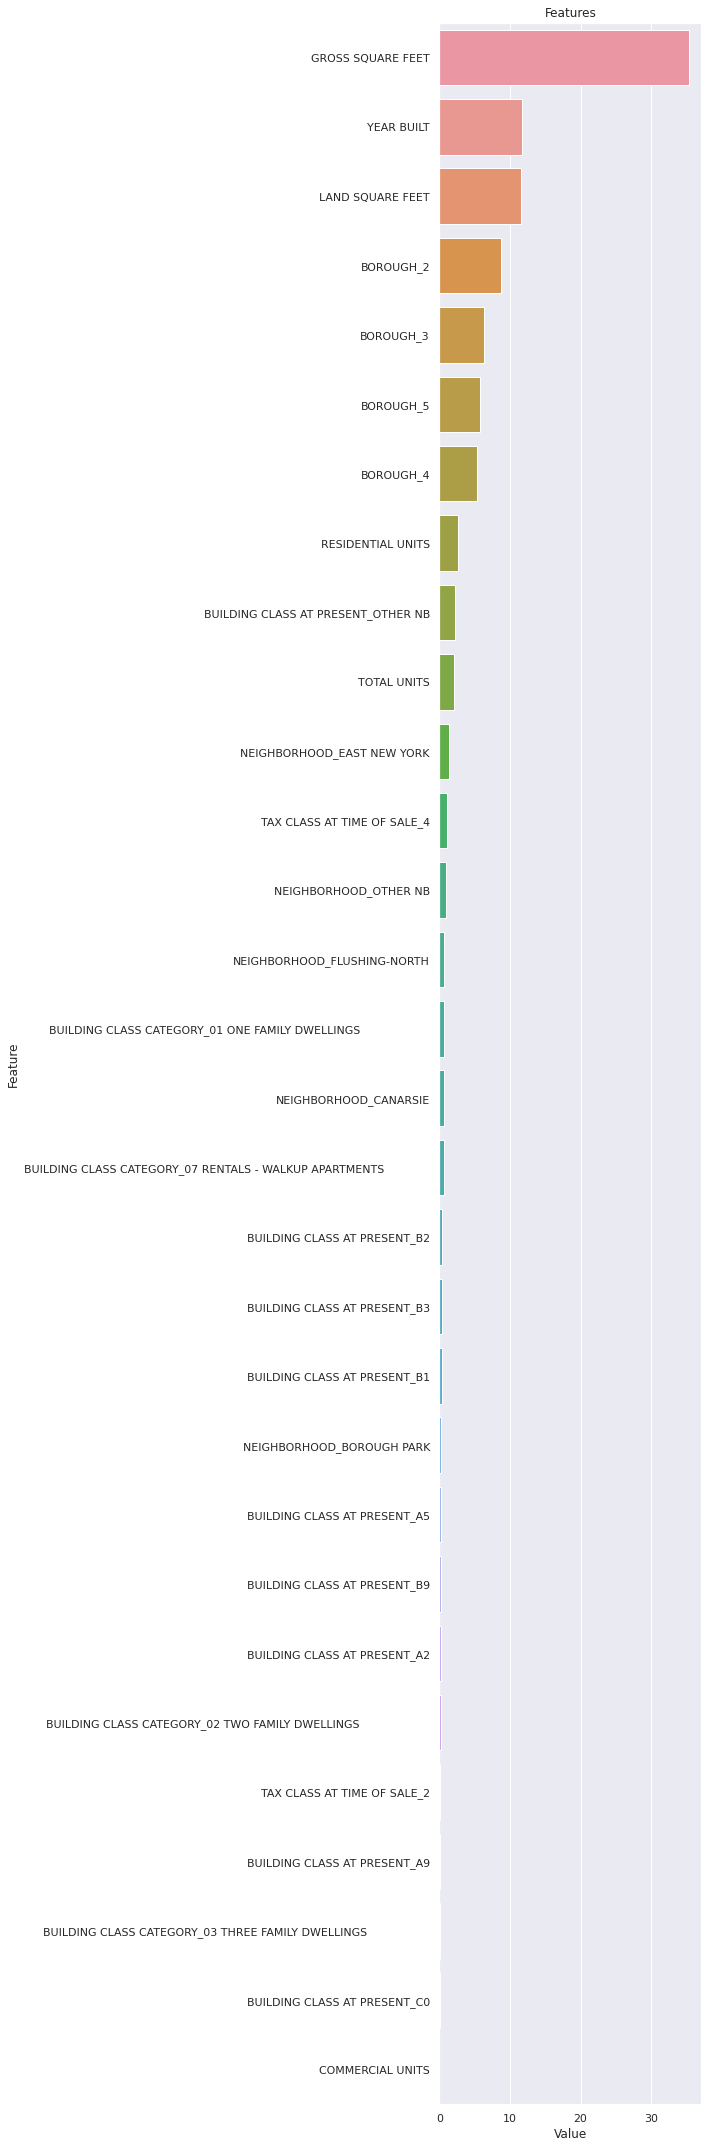

In [59]:
#######################################
# FEATURE IMPORTANCE
#######################################

def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 30))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_final, X_train)



In [60]:
feature_imp = pd.DataFrame({'Value': catboost_final.feature_importances_, 'Feature': X_train.columns})

In [61]:
importance_zero = feature_imp[feature_imp["Value"] == 0]["Feature"].values
importance_zero

array(['COMMERCIAL UNITS'], dtype=object)

In [62]:
cols = df.columns

In [63]:
imp_feats = [col for col in cols if col not in importance_zero]
imp_feats

['RESIDENTIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'SALE PRICE',
 'NEIGHBORHOOD_BOROUGH PARK',
 'NEIGHBORHOOD_CANARSIE',
 'NEIGHBORHOOD_EAST NEW YORK',
 'NEIGHBORHOOD_FLUSHING-NORTH',
 'NEIGHBORHOOD_OTHER NB',
 'BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                    ',
 'BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                    ',
 'BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS                  ',
 'BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS             ',
 'BUILDING CLASS AT PRESENT_A2',
 'BUILDING CLASS AT PRESENT_A5',
 'BUILDING CLASS AT PRESENT_A9',
 'BUILDING CLASS AT PRESENT_B1',
 'BUILDING CLASS AT PRESENT_B2',
 'BUILDING CLASS AT PRESENT_B3',
 'BUILDING CLASS AT PRESENT_B9',
 'BUILDING CLASS AT PRESENT_C0',
 'BUILDING CLASS AT PRESENT_OTHER NB',
 'TAX CLASS AT TIME OF SALE_2',
 'TAX CLASS AT TIME OF SALE_4',
 'BOROUGH_2',
 'BOROUGH_3',
 'BOROUGH_4',
 'BOROUGH_5']

In [64]:
df = df[imp_feats]

## Final Model

In [65]:
train_df = df[df['SALE PRICE'].notnull()]
test_df = df[df['SALE PRICE'].isnull()]

y = train_df['SALE PRICE']
X = train_df.drop(["SALE PRICE"], axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=46)

catboost_model = CatBoostRegressor(random_state=46, verbose=False)

catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=46).fit(X_train, y_train)

In [67]:
##########################
# TUNED MODEL TRAIN HATASI
##########################
y_pred = catboost_final.predict(X_train)

print("Catboost Tuned Model Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred)))

##########################
# TUNED MODEL TEST HATASI
##########################

y_pred = catboost_final.predict(X_test)
print("Catboost Tuned Model Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


Catboost Tuned Model Train RMSE: 0.42924837035432845
Catboost Tuned Model Test RMSE: 0.4874439397770261


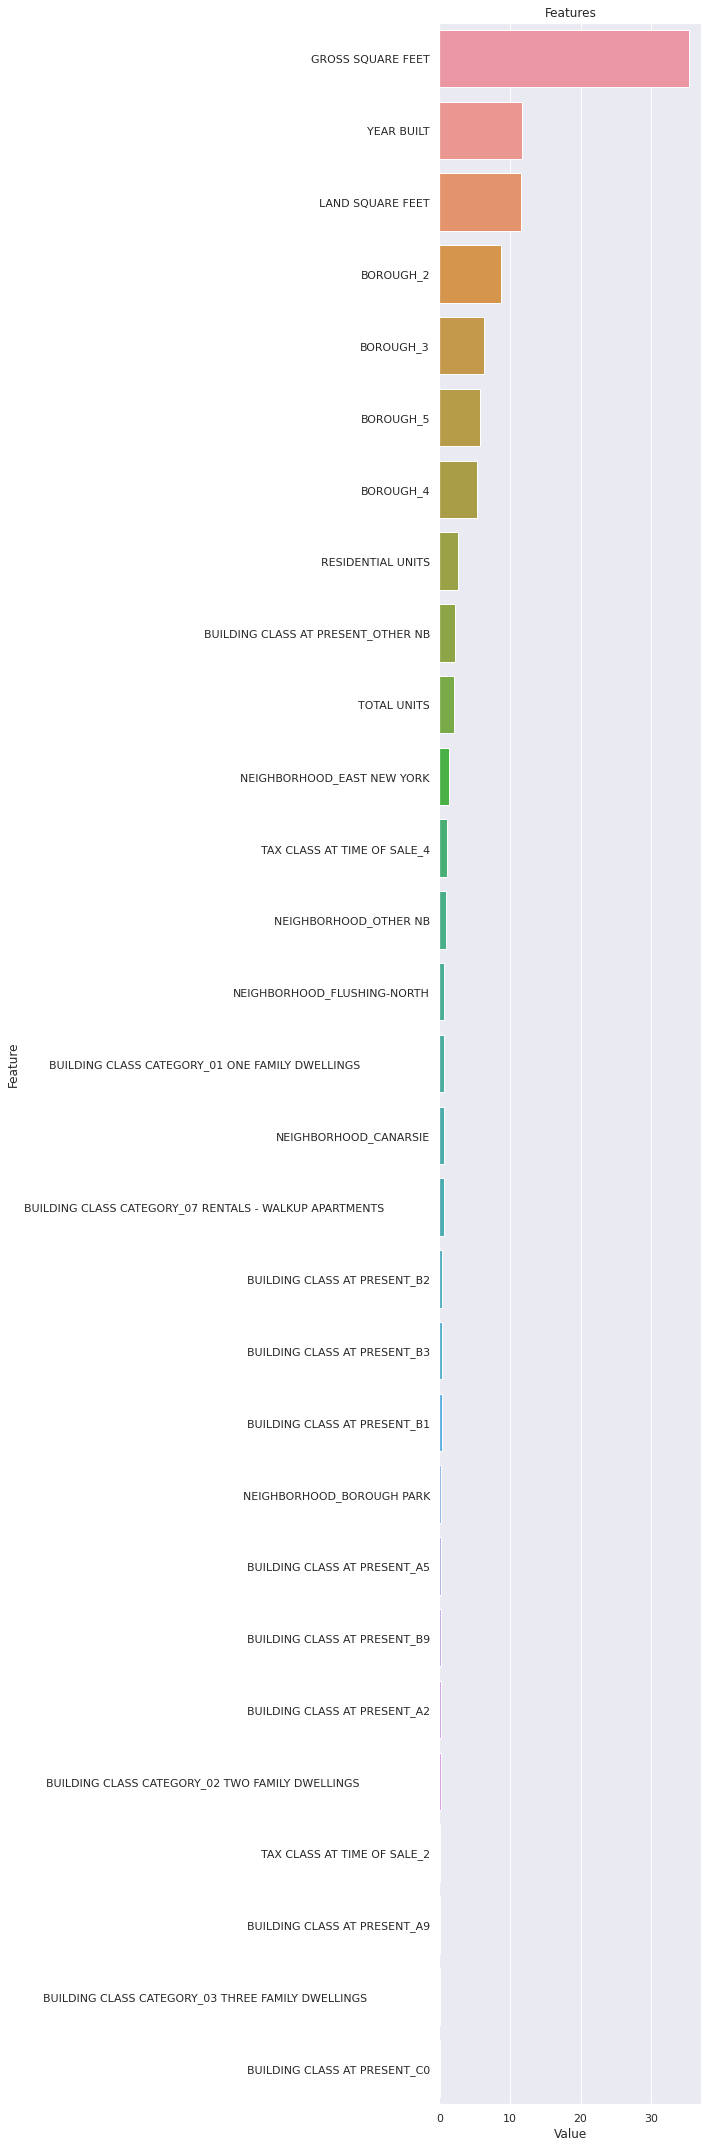

In [68]:
#######################################
# FEATURE IMPORTANCE
#######################################

def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 30))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_final, X_train)